In [35]:
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV #网格搜索
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve
import warnings
warnings.filterwarnings("ignore")


In [36]:
def rebalance(data, labels, less_label, more_label, resample_rate):
    assert len(labels.shape) == 1
    assert data.shape[0] == labels.shape[0]
    assert resample_rate > 1
    less_data = data[labels == less_label]
    less_num = labels[labels == less_label].sum() // less_label
    more_num = labels.shape[0] - less_num
    assert more_num > less_num
    assert less_num * resample_rate < more_num
    more_data = data[labels != less_label]

    # print(less_data.shape)
    for i in range(math.floor(resample_rate)-1):
        if i == 0:
            rebalanced_less_data = np.concatenate([less_data, less_data])
        else:
            rebalanced_less_data = np.concatenate([rebalanced_less_data, less_data])

    random_sample_rate = resample_rate - math.floor(resample_rate)
    mask = np.random.choice([True, False], size=int(less_num), p=[random_sample_rate, 1-random_sample_rate])
    # print(mask.shape)
    tmp_less_data = less_data[mask,:]
    rebalanced_less_data = np.concatenate([rebalanced_less_data, tmp_less_data])
    rebalanced_less_labels = np.zeros(rebalanced_less_data.shape[0], dtype=np.uint8) + less_label
    print('less shape:',rebalanced_less_data.shape)

    # more downsample
    sample_prob = less_num * resample_rate / more_num
    mask = np.random.choice([True, False], size=int(more_num), p=[sample_prob, 1-sample_prob])
    sampled_more_data = more_data[mask,:]
    sampled_more_labels = np.zeros(sampled_more_data.shape[0], dtype=np.uint8) + more_label
    print('more shape:', sampled_more_data.shape)

    # shuffle
    rebalanced_data = np.concatenate([sampled_more_data, rebalanced_less_data])
    rebalanced_labels = np.concatenate([sampled_more_labels, rebalanced_less_labels])
    # np.random.shuffle(rebalanced_data)
    permt = np.random.permutation(rebalanced_data.shape[0])
    rebalanced_data = rebalanced_data[permt,:]
    rebalanced_labels = rebalanced_labels[permt]
    print('all shape:',rebalanced_data.shape)
    print('all labels shape:',rebalanced_labels.shape)

    return rebalanced_data, rebalanced_labels

In [37]:
# 读取csv文件
path = "/home/rcw/ML_project/Stroke_prediction_system_Data/"
train_feature_path = path + "Prf_feature_train.csv"
train_label_path = path + "Stroke_label_train.csv"
test_feature_path = path + "Prf_feature_test.csv"
train_features = pd.read_csv('/home/rcw/ML_project/train_features.csv').iloc[:, 1:]
train_labels = pd.read_csv(train_label_path).iloc[:, 1:]
test_features = pd.read_csv('/home/rcw/ML_project/test_features.csv').iloc[:, 1:]
train_array = np.array(train_features)
train_labels_array = np.array(train_labels)

np.random.seed(2023)

sampled_train_array, sampled_train_labels = rebalance(train_array, train_labels_array[:,0], 1, 2,2.2)
# sampled_train_labels -= 1 # 1,2 -> 0,1
sampled_train_labels = 2 - sampled_train_labels
# start training scripts
# train_data = xgb.DMatrix(sampled_train_array, label=sampled_train_labels) # 组成训练集
# train_data.save_binary("train.buffer")
# 划分 训练集+验证集
X_train,X_val,y_train,y_val = train_test_split(sampled_train_array, sampled_train_labels,test_size=0.3,random_state=0)

less shape: (34028, 100)
more shape: (34118, 100)
all shape: (68146, 100)
all labels shape: (68146,)


0.779885978977374 131


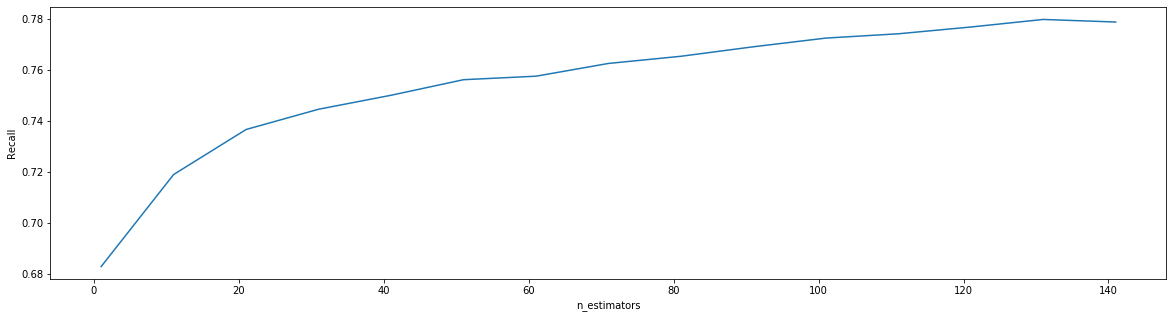

In [13]:
scorel = []
for i in range(0,150,10):
    model = xgb.XGBClassifier(n_estimators=i+1,
                                 n_jobs=-1,
                                 random_state=90).fit(X_train,y_train)
    # score = model.score(X_val,y_val)
    pred = model.predict(X_val)
    score = recall_score(pred, y_val)
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)  #作图反映出准确度随着估计器数量的变化，51的附近最好
plt.figure(figsize=[20,5])
#设置坐标轴名称
plt.xlabel('n_estimators')
plt.ylabel('Recall')
plt.plot(range(1,150,10),scorel)
plt.show()

0.8207273047459717 121


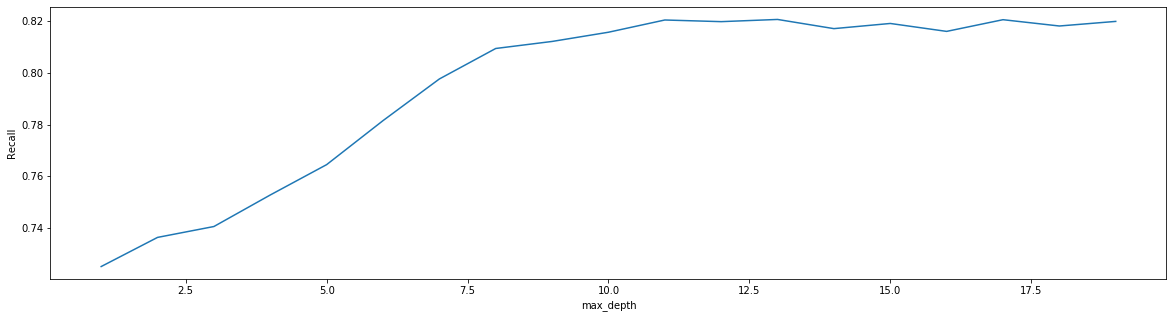

In [15]:
scorel = []
for i in range(1,20):
    model = xgb.XGBClassifier(n_estimators=150,
                                max_depth = i,
                                 n_jobs=-1,
                                 random_state=90).fit(X_train,y_train)
    # score = model.score(X_val,y_val)
    pred = model.predict(X_val)
    score = recall_score(pred, y_val)
    scorel.append(score)
print(max(scorel),(scorel.index(max(scorel))*10)+1)
plt.figure(figsize=[20,5])
#设置坐标轴名称
plt.xlabel('max_depth')
plt.ylabel('Recall')
plt.plot(range(1,20),scorel)
plt.show()

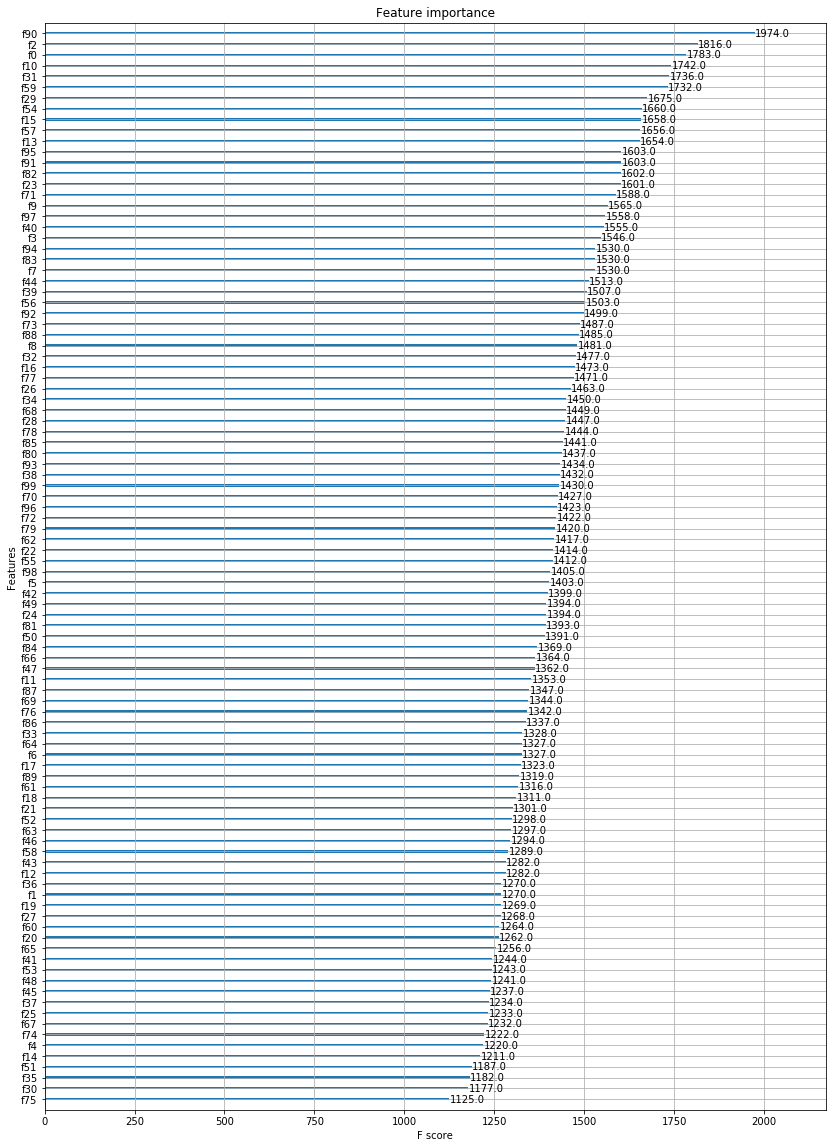

In [19]:
from xgboost import plot_importance
# plt.figure(figsize=(15,15))
plt.rcParams["figure.figsize"] = (14, 20)

model = xgb.Booster(model_file='/home/rcw/ML_project/train_best_2023-01-05 00:07:10.242018.model')

plot_importance(model)

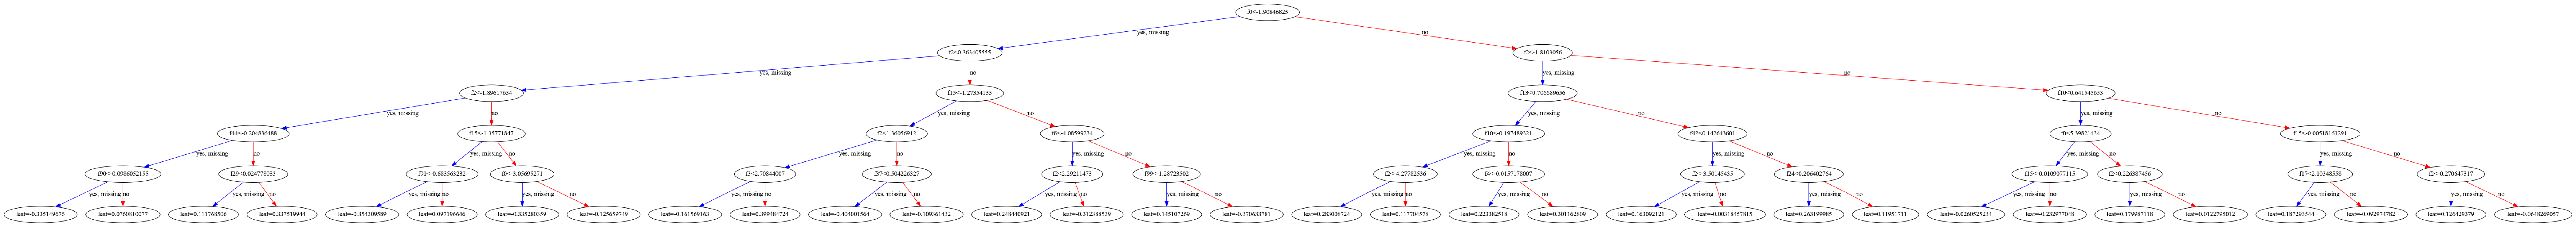

In [55]:
xgb.plot_tree(model_vis, num_trees=1)#, fmap='xgb.fmap')
fig = plt.gcf()
fig.set_size_inches(150, 50)
#plt.show()
fig.savefig('tree.png')



Recall: 0.9785557260773985
Precision: 0.9908025702406451
Accuracy: 0.9845708775313404
F1: 0.9846410684474124
AUC: 0.9846366559009889


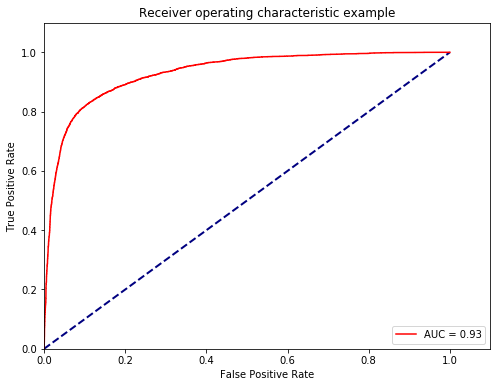

In [6]:
# ROC曲线、AUC
from sklearn.metrics import precision_recall_curve
from sklearn import metrics
import pickle
# 预测正例的概率
# y_pred_prob=model.predict(xgb.DMatrix(X_val))
xgb_model_loaded = pickle.load(open("cross_val_best.pkl", "rb"))
    
# import pdb;pdb.set_trace()
    # test
# print(xgb_model_loaded.predict(test_features))
y_pred_prob = xgb_model_loaded.predict_proba(X_val)[:,1]

y_pred = xgb_model_loaded.predict(X_train)
recall = recall_score(y_pred, y_train)
print('Recall:', recall)
precision = precision_score(y_pred, y_train)
print('Precision:', precision)
acc = accuracy_score(y_pred, y_train)
print('Accuracy:', acc)
f1 = f1_score(y_pred, y_train)
print('F1:', f1)
fpr, tpr, thresholds = roc_curve(y_pred, y_train, pos_label=1)
AUC = auc(fpr, tpr)
print('AUC:', AUC)

# print(y_pred_prob)
fpr, tpr, thresholds = metrics.roc_curve(y_val,y_pred_prob, pos_label=1)
#pos_label，代表真阳性标签，就是说是分类里面的好的标签，这个要看你的特征目标标签是0,1，还是1,2
roc_auc = metrics.auc(fpr, tpr)  #auc为Roc曲线下的面积
# print(roc_auc)
plt.figure(figsize=(8,6))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr, tpr, 'r',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
# plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1.1])
plt.ylim([0, 1.1])
plt.xlabel('False Positive Rate') #横坐标是fpr
plt.ylabel('True Positive Rate')  #纵坐标是tpr
plt.title('Receiver operating characteristic example')
plt.show()

In [31]:
# 读取csv文件
path = "/home/rcw/ML_project/Stroke_prediction_system_Data/"
train_feature_path = path + "Prf_feature_train.csv"
train_label_path = path + "Stroke_label_train.csv"
test_feature_path = path + "Prf_feature_test.csv"
# 删去第一列
train_features = pd.read_csv(train_feature_path).iloc[:, 1:]
train_labels = pd.read_csv(train_label_path).iloc[:, 1:]
test_features = pd.read_csv(test_feature_path).iloc[:, 1:]
print(train_features.shape)
print(train_labels.shape)
print(test_features.shape)
# 数据预处理
train_features.fillna(0, inplace=True)

(400000, 299)
(400000, 1)
(33119, 299)


In [33]:
train_features = train_features.iloc[:,:30]

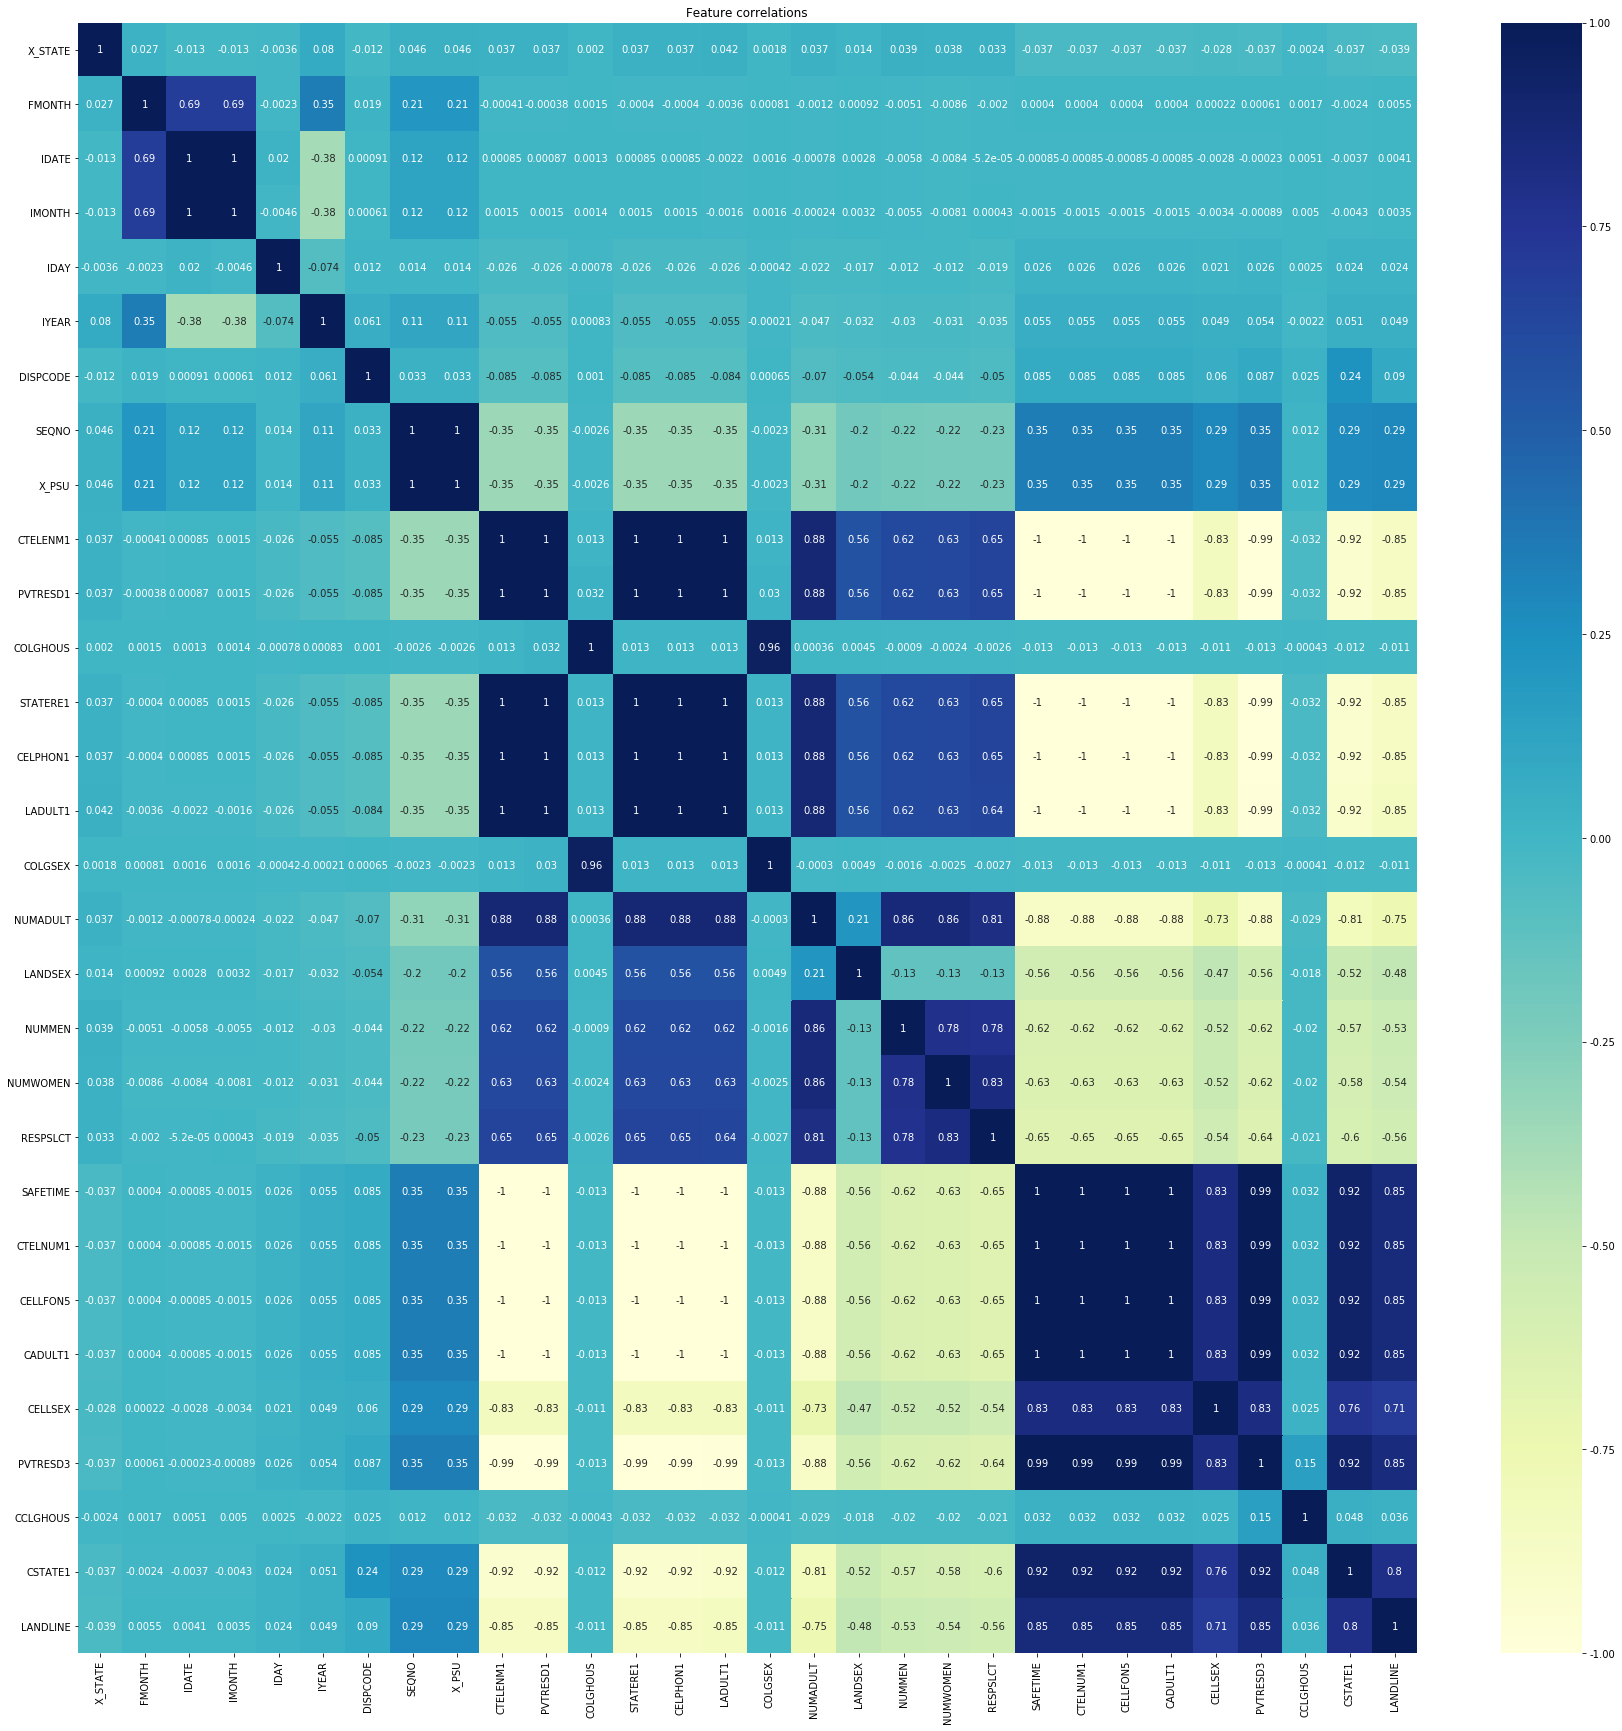

In [34]:
plt.figure(figsize=(30,30))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
sns.heatmap(train_features.corr(),cmap="YlGnBu",annot=True)
plt.title("Feature correlations")
plt.show()